<h1 style="background-color: #8EBAD9;
            font-size: 2.5em;
            color: #03112A;
            border-radius: 25px;
            text-align: center;
            padding: 20px;
            font-family: 'Verdana', sans-serif;
            box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.2);">
   <span style="font-weight: bold;"> Part 1 : online adevertising.</span>
</h1>


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

<div dir="rtl" style="text-align: right;">
<strong>מגישים : </strong> <br>
 רז אלבז <br>
 נועה ענקי

#### קבוצה : 16

#### Git Link :

<div style="text-align: right;">
    <a href="https://github.com/Razelbaz1/Bayesian_models_project" target="_blank">
        קישור לכל הפרויקט ב - GitHub
    </a>
</div>


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd

## Online advertising

### You are in charge of online advertising.

### Your company has five different types of commercials that it can use.
### There are 200 attempts for advertising, and of course, advertising costs money. 
### The income can come from a single advertisement and can be any integer from 0 to 20.

# Tasks
### 1. (4%) Please suggest a strategy for choosing which commercial to use each time. Please code it. 
### 2. (2%) Please track the number of commercials used for each type and plot a histogram.
### 3. (4%) Which commercial type was used the most? Giving the true probabilities for each possible value for each commercial, does this result make sense? Explain!


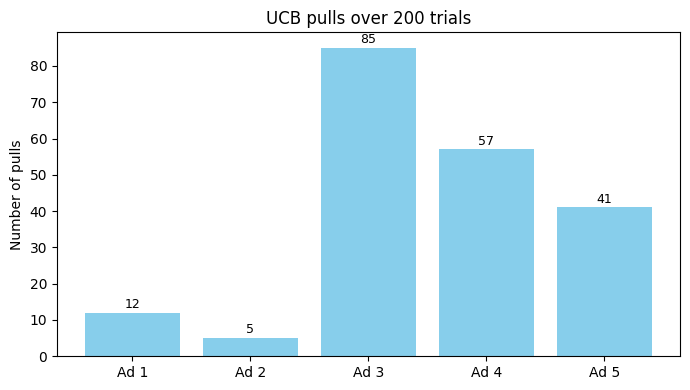

Most used ad type: Ad 3

Probabilities P(r=0..20) by ad (rows):
         r=0     r=1     r=2     r=3     r=4     r=5     r=6     r=7     r=8     r=9    r=10    r=11    r=12    r=13    r=14    r=15    r=16    r=17    r=18    r=19    r=20
Ad 1  0.0284  0.0425  0.0195  0.0602  0.0175  0.0155  0.0749  0.0018  0.0026  0.0922  0.0377  0.1186  0.1564  0.0175  0.0064  0.1613  0.0862  0.0107  0.0176  0.0068  0.0257
Ad 2  0.0145  0.0648  0.2195  0.0522  0.0110  0.0050  0.1896  0.0043  0.0217  0.0089  0.0570  0.0005  0.1140  0.0304  0.0223  0.0008  0.0491  0.0179  0.0799  0.0307  0.0057
Ad 3  0.0744  0.0579  0.0205  0.0178  0.0226  0.0200  0.0036  0.1242  0.1566  0.0013  0.0476  0.0299  0.0226  0.0886  0.1141  0.0335  0.0062  0.0263  0.0389  0.0752  0.0181
Ad 4  0.0346  0.0627  0.0442  0.0548  0.0091  0.0406  0.0058  0.1060  0.0115  0.0388  0.0453  0.1053  0.0447  0.0375  0.0209  0.1341  0.0458  0.0155  0.0070  0.0641  0.0717
Ad 5  0.0019  0.0081  0.0356  0.0461  0.0154  0.0504  0.0152  0.0189  0

In [31]:
# -----------------------------
# 1) Load true probabilities
# -----------------------------
with open("multi_16.pkl", "rb") as f:
    true_probs = pkl.load(f)       # shape expected: (5, 21)
true_probs = np.asarray(true_probs)
assert true_probs.shape == (5, 21), f"Expected (5,21), got {true_probs.shape}"
# כל שורה אמורה להסתכם ל-1 (התפלגות על 0..20)
row_sums = true_probs.sum(axis=1)
assert np.allclose(row_sums, 1, atol=1e-6), "Each row must sum to 1 (probabilities)."

# -----------------------------
# 2) Problem constants
# -----------------------------
possible_vals = np.arange(21)     # 0..20
num_machines = true_probs.shape[0]
num_outcomes = true_probs.shape[1]
num_trials = 200
rng = np.random.default_rng(42)   # ניתן לשנות/להסיר ל-repro

# ------------------------------------------------
# 3) UCB for categorical rewards with Dirichlet posterior
#    - נאתחל אלפא=1 (prior אחיד) לכל פרסומת ולכל תוצאה
#    - בכל צעד: נחשב תוחלת פוסטריורית + בונוס חקירה
# ------------------------------------------------
def ucb_advertising(true_probs, num_trials=200, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    num_machines, num_outcomes = true_probs.shape
    possible_vals = np.arange(num_outcomes)  # כאן 0..20

    # אלפא של דיריכלה (Posterior counts); אתחול אחיד 1
    alpha = np.ones((num_machines, num_outcomes), dtype=float)

    # Book-keeping
    pulls_per_ad = np.zeros(num_machines, dtype=int)
    rewards_history = []

    # אתחול UCB: מושכים כל פרסומת פעם אחת, כדי להימנע מחלוקה ב-0
    for arm in range(num_machines):
        outcome_idx = rng.choice(num_outcomes, p=true_probs[arm])
        alpha[arm, outcome_idx] += 1
        pulls_per_ad[arm] += 1
        rewards_history.append(possible_vals[outcome_idx])

    # ריצת UCB לשאר הסבבים
    for t in range(num_machines + 1, num_trials + 1):
        # תוחלת פוסטריורית של הרווח לכל פרסומת: E[r] = E[θ]·values
        post_means = (alpha / alpha.sum(axis=1, keepdims=True)) @ possible_vals

        # N_t(r): מספר משיכות אמיתי לכל פרסומת (ללא האלפא ההתחלתית)
        Nt = alpha.sum(axis=1) - num_outcomes
        # בונוס חקירה; מגן מחלוקה באפס
        bonus = np.sqrt((2.0 * np.log(t)) / np.maximum(Nt, 1e-9))
        ucb_scores = post_means + bonus

        arm = int(np.argmax(ucb_scores))

        # דגימת תוצאה אמיתית (Categorical) לפי ההסתברויות של אותה פרסומת
        outcome_idx = rng.choice(num_outcomes, p=true_probs[arm])

        # עדכון פוסטריור (Dirichlet counts) ואינדיקטורים
        alpha[arm, outcome_idx] += 1
        pulls_per_ad[arm] += 1
        rewards_history.append(possible_vals[outcome_idx])

    total_reward = int(np.sum(rewards_history))
    return {
        "pulls_per_ad": pulls_per_ad,
        "total_reward": total_reward,
        "alpha_posterior": alpha,
        "rewards_history": np.array(rewards_history),
    }

res = ucb_advertising(true_probs, num_trials=num_trials, rng=rng)

# -----------------------------
# 4) Plot: histogram of pulls
# -----------------------------
plt.figure(figsize=(7,4))
bars = plt.bar(np.arange(num_machines), res["pulls_per_ad"],color="skyblue")
plt.xticks(np.arange(num_machines), [f"Ad {i+1}" for i in range(num_machines)])
plt.ylabel("Number of pulls")
plt.title(f"UCB pulls over {num_trials} trials")
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h+0.5, str(int(h)), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

# -----------------------------
# 5) Which ad was used most?
# -----------------------------
most_used_idx = int(np.argmax(res["pulls_per_ad"]))
print(f"Most used ad type: Ad {most_used_idx+1}")

# -----------------------------
# 6) Probabilities of each profit 0..20 for each ad (the given data)
# -----------------------------
probs_df = pd.DataFrame(true_probs, columns=[f"r={v}" for v in possible_vals])
probs_df.index = [f"Ad {i+1}" for i in range(num_machines)]
print("\nProbabilities P(r=0..20) by ad (rows):")
print(probs_df.round(4).to_string())



True expected revenue per ad:
Ad 1    10.539
Ad 2     8.042
Ad 3     9.863
Ad 4    10.487
Ad 5    13.249


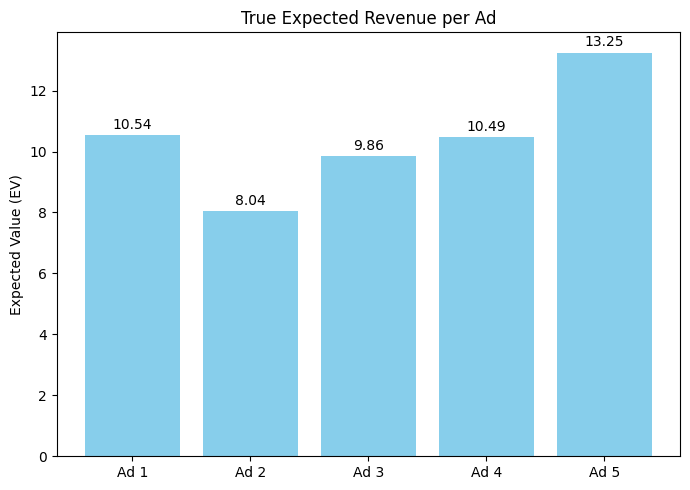

In [33]:
# Data (expected values calculated before)
true_ev = true_probs @ possible_vals
ev_df = pd.Series(true_ev, index=[f"Ad {i+1}" for i in range(num_machines)], name="True EV")
print("\nTrue expected revenue per ad:")
print(ev_df.round(3).to_string())

true_ev = np.array([ev_df.round(3).values[0],ev_df.round(3).values[1],ev_df.round(3).values[2],ev_df.round(3).values[3],ev_df.round(3).values[4]])
ads = [f"Ad {i+1}" for i in range(len(true_ev))]

# Plot
plt.figure(figsize=(7,5))
bars = plt.bar(ads, true_ev, color="skyblue")
plt.title("True Expected Revenue per Ad")
plt.ylabel("Expected Value (EV)")
for b, ev in zip(bars, true_ev):
    plt.text(b.get_x()+b.get_width()/2, ev+0.1, f"{ev:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;" dir="rtl">

# 📊 פרסום מקוון – תוצאות אסטרטגיית UCB

## 1. אסטרטגיה וקוד

<div dir="rtl"

בחרנו לממש את אסטרטגיית **Upper Confidence Bound (UCB)**.  
בכל שלב האלגוריתם מחשב לכל פרסומת ציון:

$$
\hat{\mu}_r + \sqrt{\tfrac{2 \ln (t)}{N_t(r)}}
$$

<div dir="rtl"

- \\(\hat{\mu}_r\\) : התוחלת הפוסטריורית של הרווח עבור פרסומת \\(r\\).  
- \\(t \\): מספר הניסיונות הכולל עד כה.  
- \\(N_t(r)\\): מספר הפעמים שנבחרה פרסומת \\(r \\).  

<div dir="rtl"

כך נשמר איזון בין **חקירה** של פרסומות שנוסו מעט לבין **ניצול** של פרסומות שנראות מבטיחות.  
בכל ניסיון נבחרת הפרסומת עם הציון הגבוה ביותר, מדגמים ממנה רווח אמיתי לפי ההתפלגות הנתונה (0–20), ומעדכנים את הפוסטריור.

---

## 2. ספירת שימושים (לפי היסטוגרמה)

<div dir="rtl"

במהלך **200 ניסיונות** התקבל:

- פרסומת 1 → 12 פעמים  
- פרסומת 2 → 5 פעמים  
- **פרסומת 3 → 85 פעמים**  
- פרסומת 4 → 57 פעמים  
- פרסומת 5 → 41 פעמים  

<div dir="rtl"

ההיסטוגרמה מראה שהאלגוריתם התכנס בצורה ברורה לעדיפות על פרסומת 3.

---

## 3. איזו פרסומת נבחרה הכי הרבה והאם זה הגיוני?

<div dir="rtl"

הפרסומת שנבחרה הכי הרבה היא **פרסומת 3 (85 פעמים)**.  
עם זאת, חישוב **התוחלת האמיתית של הרווח** לכל פרסומת (חיבור משוקלל של כל הרווחים 0–20 לפי ההסתברויות) מראה:

- פרסומת 1 → 10.54  
- פרסומת 2 → 8.04  
- פרסומת 3 → 9.86  
- פרסומת 4 → 10.49  
- **פרסומת 5 → 13.25 (הגבוהה ביותר)**  

<div dir="rtl"

כלומר בפועל **פרסומת 5** היא הטובה ביותר.  
העובדה ש־UCB העדיף את פרסומת 3 לאחר 200 ניסיונות מצביעה על כך שעם מספר ניסיונות קטן יחסית האלגוריתם עלול להתכנס לאפשרות "טובה מספיק" אך לא מיטבית.  
במספר ניסיונות גדול יותר צפוי שהאלגוריתם יזהה את פרסומת 5 כטובה ביותר ויבחר בה לעיתים תכופות יותר.

---

## ✅ סיכום
1. בחרנו באסטרטגיית **UCB** כפתרון לאיזון בין חקירה לניצול.  
2. עקבנו אחרי מספר הפעמים שנבחרה כל פרסומת והצגנו זאת בהיסטוגרמה.  
3. האלגוריתם בחר הכי הרבה ב־**פרסומת 3**, אך לפי ההסתברויות האמיתיות **פרסומת 5** היא בעלת התוחלת הגבוהה ביותר.  
   לכן, התוצאה סבירה בטווח הקצר אך בטווח הארוך היינו מצפים ליותר בחירה בפרסומת 5.
